# Influenza epidemic model

**Based on actual data:** In 1978, an outbreak of inﬂuenza was reported in a boarding school for boys in the United Kingdom. The single outbreak is modelled using the classical SIR compartmental model given by the following set of nonlinear differential equations
\begin{align*}
\frac{\mathrm{d} S}{\mathrm{d} t}&=-\beta \frac{SI}{N},\\
\frac{\mathrm{d} I}{\mathrm{d} t}&= \beta\frac{SI}{N} - \gamma I,\\
\frac{\mathrm{d} R}{\mathrm{d} t}&=\gamma I,
\end{align*}
where
* $N$ is the total population (note that $S(t)+I(t)+R(t)=S(0)+I(0)+R(0)=N$).
* $S(t)$ denotes the susceptible population, i.e. those who are not (yet) infected;
* $I(t)$ denotes the infected population, assumed to be infectious and able to spread the disease by contact with susceptibles;
* $R(t)$ denotes the removed population, i.e. those who recover, who are assumed to gain immunity from the disease.

This model is the classical Kermack and McKendrick model developed in 1927. Extensions of this model are being used to model COVID-19. Here
* $\beta$ measures the infection rate in units of 1/days. The probability of a random contact of an infected person with a susceptible one $S/N$. Hence the number of new infections per unit time per infective is $\beta S/N$. There are $I$ infectives making $\beta$ infectious contacts per unit time, giving the rate of new infections per unit time as $\beta SI/N$.
* $\gamma$ is the recovery rate in units of 1/days. Roughly speaking $1/\gamma$ corresponds to the time an individual remains in the infected class.

| Days | Cases|
|------|-----|
| 3 |  25|
| 4 |  75|
| 5 | 228|
| 6 | 297|
| 7 | 259|
| 8 | 235|
| 9 | 192|
|10 | 126|
|11 |  71|
|12 |  28|
|13 |   9|
|14 |   7|

The quantity $\beta S(0)/(\gamma N)$ is a threshold quantity, called the **basic reproduction number** and denoted by $\mathcal{R}_0$, which determines whether there is an epidemic. If $\mathcal{R}_0<1$, the disease is eradicated, whereas if $\mathcal{R}_0>1$ there is an epidemic. It is a measure of the number of secondary infections caused by a single infective introduced into a wholly susceptible population of size $S(0)\approx N$, so that $\mathcal{R}_0$ is also usually defined as $\beta/\gamma$. In this sense, the **effective reproductive number** is
$$
\mathcal{R}(t)=\frac{\beta S(t)}{\gamma N}
$$
We wish to (i) gauge how well this model agrees with actual epidemiological data and (ii) try to examine a number of scenarios should a similar outbreak occur. 

### Implement the RK4 scheme

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate

# Runge–Kutta 4
def rk4(ODE,T,Y0,N,*args): 
    # Number of iterations
    t = np.linspace(T[0],T[1],num=N+1) 
    y = np.zeros([N+1,len(Y0)])
    y[0] = Y0
    h = float((T[1]-T[0])/N)
    # Iterate for number of iterations 
    for i in range(N): 
        k1 = h*ODE(y[i],t[i],*args)
        k2 = h*ODE(y[i]+0.5*k1,t[i]+0.5*h,*args)
        k3 = h*ODE(y[i]+0.5*k2,t[i]+0.5*h,*args)
        k4 = h*ODE(y[i]+k3,t[i]+h,*args) 
        y[i+1] = y[i] + (k1+2*k2+2*k3+k4)/6.
  
    return t,y

### Fit the epidemiological data to the model

The code that follows, fits the data
$$
y = \mathrm{e}^{-t/4}\left(\sin(t) +\{noise\}\right)
$$
to the differential equation
$$
y''+a y' + by=0
$$
subject to the appropriate initial conditions $y(0)=y_0$ and $y'(0)=u_0$. The ODE is written as a system as follows
$$
\begin{pmatrix}
y\\
y'\end{pmatrix}' = \begin{pmatrix}
0 & 1\\
-b& - a
\end{pmatrix}\begin{pmatrix}
y\\
y'\end{pmatrix}
$$
'Experimental' data and plot

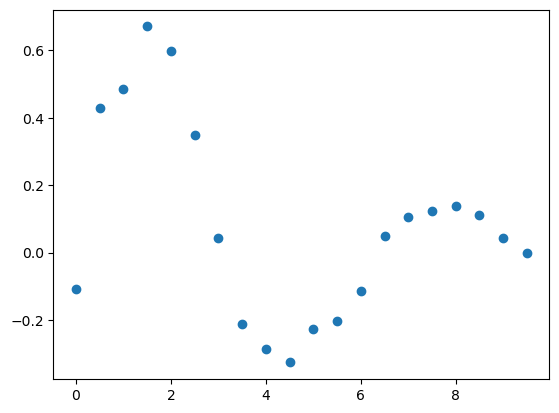

In [12]:
t_exp = np.arange(20)/2
y_exp = np.exp(-t_exp/4)*(np.sin(t_exp)+0.1*np.random.randn(20))
plt.plot(t_exp,y_exp,'o')

Fit of the data

a: theory a = 0.5;  fit 0.4587
b: theory b =   1;  fit 1.0087


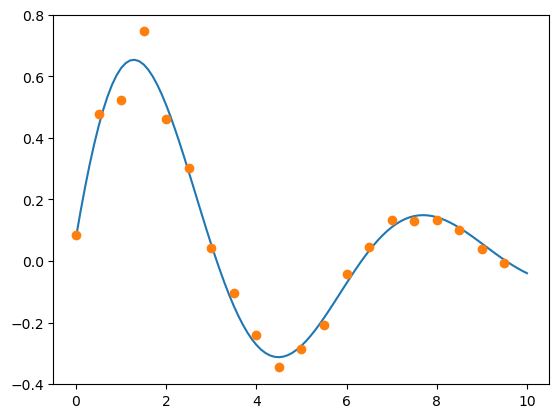

In [3]:
def odemodel(u,t,a,b):
    return np.array([u[1],-b*u[0]-a*u[1]])

def fitODE(tdata,a,b,y0,u0):
    # Solve the ODE model using RK2
    tm,ym = rk2(odemodel,[0,10],np.array([y0,u0]),100,a,b)
    
    # Perform a interpolation at tdata for ym[:,0]
    f = interpolate.interp1d(tm,ym[:,0])
    return f(tdata)

# Fit the model to the data
pfit, _ = curve_fit(f=fitODE,xdata=t_exp,ydata=y_exp)
tfit,yfit = rk2(odemodel,[0,10],np.array([pfit[2],pfit[3]]),100,pfit[0],pfit[1])

plt.plot(tfit,yfit[:,0],t_exp,y_exp,'o')
print('a: theory a = 0.5;  fit %1.4f' % pfit[0])
print('b: theory b =   1;  fit %1.4f' % pfit[1])

##### Assuming $N=762$, $I(0)=1$ and $R(0)=0$ we fit the the 2 parameters $\beta$ and $\gamma$ of the epidemiological data

beta  = 1.6678
gamma = 0.4410


C:\Users\Charalambos\AppData\Local\Temp\ipykernel_24028\1446070769.py:6: RuntimeWarning: overflow encountered in double_scalars
  return np.array([-beta*u[0]*u[1]/N,beta*u[0]*u[1]/N-gamma*u[1],gamma*u[1]])


[]

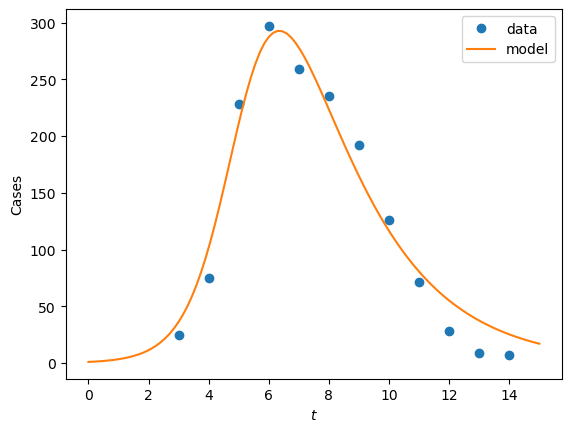

In [13]:
t_exp = np.arange(3,15)
i_exp = np.array([25, 75, 228, 297, 259, 235, 192, 126, 71, 28, 9, 7])
N = 762

def SIRmodel(u,t,beta,gamma):
    return np.array([-beta*u[0]*u[1]/N,beta*u[0]*u[1]/N-gamma*u[1],gamma*u[1]])

def fitSIR(tdata,beta,gamma):
    # Solve the ODE model using RK2
    tm,ym = rk4(SIRmodel,[0,15],np.array([N-1,1,0]),100,beta,gamma)
    
    # Perform a interpolation at tdata for ym[:,0]
    f = interpolate.interp1d(tm,ym[:,1])
    return f(tdata)

# Fit 
pfit, _ = curve_fit(f=fitSIR,xdata=t_exp,ydata=i_exp)
tfit,yfit = rk4(SIRmodel,[0,15],np.array([N-1,1,0]),100,pfit[0],pfit[1])

print('beta  = %1.4f' % pfit[0])
print('gamma = %1.4f' % pfit[1])

plt.plot(t_exp,i_exp,'o',label='data')
plt.plot(tfit,yfit[:,1],label='model')
plt.xlabel('$t$')
plt.ylabel('Cases')
plt.legend()
plt.plot()

[]

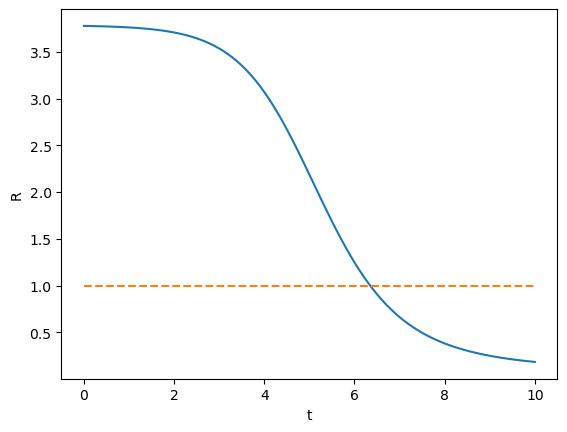

In [14]:
beta = pfit[0]
gamma = pfit[1]
tfit,yfit = rk4(SIRmodel,[0,10],np.array([N-1,1,0]),100,beta,gamma)
plt.plot(tfit,beta*yfit[:,0]/(N*gamma))
plt.plot([0,10],[1,1],'--')
plt.xlabel('t')
plt.ylabel('R')
plt.plot()

From the plot above, we see that $R$ falls below 1 after about 6 days

### Examine numerically the following two scenarios

* **Scenario 1** students practise social distancing, e.g. they halve the infectious contacts per day;

* **Scenario 2** no medical intervention is available, which doubles the time to recovery.


[]

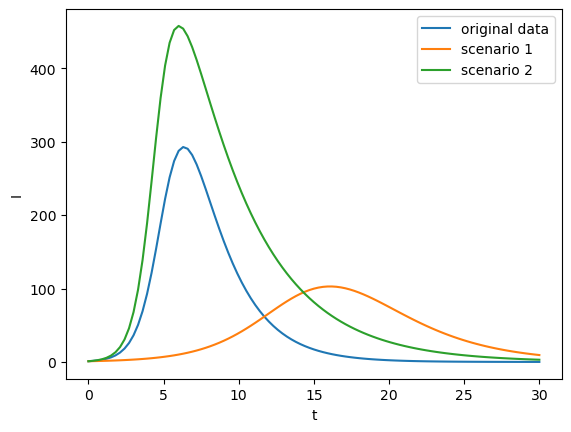

In [15]:
tfit,yfit = rk4(SIRmodel,[0,30],np.array([N-1,1,0]),100,beta,gamma)
tfit1,yfit1 = rk4(SIRmodel,[0,30],np.array([N-1,1,0]),100,beta/2,gamma)
tfit2,yfit2 = rk4(SIRmodel,[0,30],np.array([N-1,1,0]),100,beta,gamma/2)
plt.plot(tfit,yfit[:,1],label='original data')
plt.plot(tfit1,yfit1[:,1],label='scenario 1')
plt.plot(tfit2,yfit2[:,1],label='scenario 2')
plt.legend()
plt.xlabel('t')
plt.ylabel('I')
plt.plot()

In [16]:
print('Students remaining healthy')
print('   Baseline : %1d' % np.floor(yfit[-1,0]))
print('   Scenario1: %1d' % np.floor(yfit1[-1,0]))
print('   Scenario2: %1d' % np.floor(yfit2[-1,0]))

Students remaining healthy
   Baseline : 19
   Scenario1: 187
   Scenario2: 0
